<font color='blue'> Привет! Вижу, ты проделал большую работу над проектом. Ниже, как всегда ты сможешь найти мои комментарии выделенные синим. Постарайся учесть их вдальнейшем. </font>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

#### Описание данных:
-    airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
-    balcony — число балконов
-    ceiling_height — высота потолков (м)
-    cityCenters_nearest — расстояние до центра города (м)
-    days_exposition — сколько дней было размещено объявление (от публикации до снятия)
-    first_day_exposition — дата публикации
-    floor — этаж
-    floors_total — всего этажей в доме
-    is_apartment — апартаменты (булев тип)
-    kitchen_area — площадь кухни в квадратных метрах (м²)
-    last_price — цена на момент снятия с публикации
-    living_area — жилая площадь в квадратных метрах(м²)
-    locality_name — название населённого пункта
-    open_plan — свободная планировка (булев тип)
-    parks_around3000 — число парков в радиусе 3 км
-    parks_nearest — расстояние до ближайшего парка (м)
-    ponds_around3000 — число водоёмов в радиусе 3 км
-    ponds_nearest — расстояние до ближайшего водоёма (м)
-    rooms — число комнат
-    studio — квартира-студия (булев тип)
-    total_area — площадь квартиры в квадратных метрах (м²)
-    total_images — число фотографий квартиры в объявлении

#### Задачи, которые предстоит решить:
- Пострить гистограммы для параметров: площадь, цена, число комнат, высота потолков.
- Описать, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?
- Убрать выбросы.
- Изучить зависимость цены от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучить зависимость от даты размещения: дня недели, месяца и года.
- Посчитать среднюю цену квадратного метра в 10 населенных пунктах, с наибольшим числом объявлений. Выделить пункты с самой высокой и самой низкой ценой жилья.
- Проанализировать для Санкт-Петербурга, как цена зависит от удалённости от центра. Определить границу центральной зоны.
- Проанализировать сегмент квартир в центре: площадь, цена, число комнат, высота потолков. Выделить факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Отличия от общих по городу.

### Шаг 1. Изучаем общую информацию о данных.

Импортируем необходимые библиотеки

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

Считываем таблицу из .csv файла

In [317]:
realty_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Взглянем на полученную таблицу

In [318]:
realty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [319]:
realty_data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

Имеем таблицу с данными о продажах недвижимости, состоящую из 22 столбцов и 23699 строк.\
Во многих строках есть пропущенные значения, особенно много их в столбцах is_apartment, balcony, parks_nearest, ponds_nearest.

<font color='blue'> Можно и поподробнее проанализировать сырые данные, не только констатировать наличие пропусков, но и предположить их природу и метод заполнения, а также отметить где стоит изменить тип данных. </font>

Вероятно, пропуски возникли из-за того, что пользователи не заполнили некотороые поля, или вызваны ошибками работы системы, если речь идет о столбцах, заполняемых автоматически.\
Оценим возможность заполнения пропусков в каждом из столбцов:
- **ceiling_height** - высота потолков, не думаю, что возможно найти корреляцию между этим и другими параметрами. Замена на среднее значения или медиану может исказить результаты анализа, поэтому оставим как есть.
- **living_area** - площадь квартиры. Для заполнения пропусков будем использовать невозможное значение (-1) в качестве маркера.
- **kitchen_area** - пропущенные значения площади кухни заменим по аналогии со столбцом **living_area**
- **floor** и **floors_total** - вряд ли можно предсказать этаж, на котором находится квартира и общее количество этажей по другим параметрам. Оставим пропуски не тронутыми.
- **is_apartment**  - очень много пропусков, скорее всего люди просто не заполняли эту графу. На будущее стоит поставить значение по умолчанию False, чтобы избавиться от пропусков уже на этапе заполнения данных.
- **balcony** - вероятно, пропущенное значение говорит о том, что в квартире отсутствует балкон. Однако следует подробнее изучить значения в этом столбце для выбора оптимального метода заполнения пропусков.
- **locality_name** - пропущено всего 49 значений. Возможно, некоторая недвижимость не может быть определена к определенному населенному пункту.
- столбцы **_nearest** и **_around3000** заполнялись автоматически, пропуски связаны скорее всего с тем, что система не нашла искомые объекты (парки, аэропорты и тд) в радиусе поиска. Для заполнения пропусков нужны картографические данные, которых у нас нет.
- **days_exposition** т.к. столбец заполняется автоматически при закрытии объявления, скорее всего пропущенные значения означают, что объявление еще действует (недвижимость не продана), либо оно снятно досрочно пользователем. Стоит уточнить механику заполнения этого столбца.

Столбец **first_day_exposition** имеет строковый формат, что не соответствует типу значений, в нем хранящихся. Необходимо привести его к формату даты.\
Также присутствуют столбцы с данными логического типа, которые записаны под типом данных object. Их стоит привести к типу данных bool.

### Шаг 2. Предобработка данных

#### Заполним пропущенные значения, там где это возможно.
Начнем со столбца **is_apartment**: взглянем, какие значения в нём присутствуют

In [320]:
realty_data.is_apartment.unique()

array([nan, False, True], dtype=object)

In [321]:
realty_data.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Большую часть столбца составляют пропущенные значения 'nan'\
Вторым по популярности идет False, означающее, что данная недвижимость не является апартаментами.\
Всего 50 объектов недвижимости продавались как апартаменты.\
\
Вероятно, если люди не заполняли пункт "апартаменты", то продавались не апартаменты.\
Значит стоит заменить все пропуски на "False".

In [322]:
realty_data.is_apartment = realty_data.is_apartment.fillna(False)
realty_data.is_apartment.value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

#### Теперь взглянем на столбец balcony

In [323]:
realty_data.balcony.unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [324]:
realty_data.balcony.value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Т.к. в столбце **balcony** пропущено порядка 11 тыс. значений, лучше заменить их на -1. Это будет маркером, который позволит временно исключить их из анализа.

Со столбцами **ceiling_height**, **living_area**, **kitchen_area**, **floors_total**, **days_exposition** поступим аналогичным образом.

In [325]:
columns_to_fillna = [
    'balcony', 'ceiling_height', 'living_area', 'kitchen_area', 'floors_total', 'days_exposition'
]
for column in columns_to_fillna:
    realty_data[column] = realty_data[column].fillna(-1)
    
realty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

<font color='blue'> Для балконов не самое удачное решение. Ты правильно посмотрел распределение по количеству балконов и видишь, что изначально 0 балконов имеют около 3000 квартир, а 1 балкон - примерно 4000, 2 и более балконов там меньшие цифры. После заполнения 0 получаем другую картину, 0 балконов - 15000 квартир, ну а 1 балкон естественно - 4000. В таких случаях лучше заполнить пропуски невозможным значением, например, -1. Это будет просто маркером, что данные были пропущены. При необходимости можно будет временно исключить их из анализа.</font>

#### Проанализируем пропущенные значения в столбцах, заполняемых системой:

Пропущенные значения в столбцах, оканичивающихся на **_nearest** и **_around3000** , вероятно, вызваны тем, что система не нашла искомые объекты (парки, пруды, и т.д.) в радиусе поиска. В этом случае в столбцах **_nearest** будет пропуск, а в столбцах **_around3000** - значение **0.0**).

На будущее, если система нашла 0 искомых объектов, то в соответствующем столбце **_nearest** должен записываться маркер, указывающий, что ничего не найдено (-1, например), а не пропуск, как это происходит сейчас.

Также видно, что если значение в одном столбце **_around3000** пропущено, то оно будет пропущено и в другом столбце, несмотря на то, что ищутся разные объекты. Скорее всего проблема возникает в определенных местах, где система поиска ближайших объектов дает сбой.\
Стоит проверить этот момент.

Полагаю, уместно будет заменить пропуски на невозможное значение, например **-1**.

In [326]:
columns_to_fill = [
    'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest'
]
for column in columns_to_fill:
    realty_data[column] = realty_data[column].fillna(-1)
    
realty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        23699 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           23699 non-null float64
ponds_around300

#### Приведем данные к нужным типам там, где это необходимо.

Узнаем тип данных в каждом столбце

In [327]:
realty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        23699 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           23699 non-null float64
ponds_around300

За исключением столбца first_day_exposition, все столбцы имеют верный тип данных.\
\
Приведем first_day_exposition к формату даты, и убедимся в успешности замены.

In [328]:
realty_data.first_day_exposition = pd.to_datetime(realty_data.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')
realty_data.first_day_exposition.head(1)

0   2019-03-07
Name: first_day_exposition, dtype: datetime64[ns]

Для экономии памяти, приведем столбцы с типом float64 и int64 к типу int там, где это возможно.\
Это столбцы: 'total_images', 'last_price', 'rooms', 'floors_total', 'floor', 'balcony',
'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
'ponds_around3000', 'ponds_nearest', 'days_exposition'.\
\
Запишем названия столбцов в список:

In [329]:
columns_to_change = [
    'total_images', 'last_price', 'rooms', 'floors_total', 'floor', 'balcony',
    'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
    'ponds_around3000', 'ponds_nearest', 'days_exposition'
]

Используем цикл, чтобы изменить тип данных в нужных столбцах:

In [330]:
for column in columns_to_change:
    realty_data[column] = pd.to_numeric(realty_data[column], downcast='signed')

realty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int8
last_price              23699 non-null int32
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int8
ceiling_height          23699 non-null float64
floors_total            23699 non-null int8
living_area             23699 non-null float64
floor                   23699 non-null int8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int8
locality_name           23650 non-null object
airports_nearest        23699 non-null int32
cityCenters_nearest     23699 non-null int32
parks_around3000        23699 non-null int8
parks_nearest           23699 non-null int16
ponds_around3000        236

Видим, что во всех указанных выше столбцах типы данных изменились на **int8/16/32**. Значит замена прошла успешно.

В результате оптимизации объем используемой памяти уменьшился на **50% (1.8 МБ)**, что является хорошим результатом.

<font color='blue'> Это не очень хорошая предобработка. Во-первых, пропуски лучше заполнить. Как не повлиять на данные, см. ситуацию с балконами. Наличие пропусков не хорошо. Ты видишь, что тип данных уже не поменялся (метод не сработал), какие еще методы не сработают или сработают некорректно? Во вторых, есть методы замены типа данных (из библиотеки pandas), которые работают с пропусками. Можно было хотя бы эту часть выполнить ьполностью.</font>

### Вывод

**Заполнены пропуски в столбце is_apartment, основываясь на его значении:**
- пропуск в столбце is_apartment означал, что продавались не апартаменты.

**Для остальных столбцов пропущенное значение заменено на невозможное значение (-1).\
Оно послужит маркером при последующем анализе**


**Затем была проведена работа с типами данных:**
- дата выставления объявления приведена к формату datetime64.
- для экономии ресурсов, в столбцах с целочисленными значениями тип данных float заменен на int

### Шаг 3. Добавление данных в таблицу.

**Добавим в таблицу необходимые данные:**
-   Цена квадратного метра
-   День недели, месяц, год публикации объявления
-   Этаж квартиры (первый/последний/другой)
-   Соотношение жилой и общей площади
-   Отношение площади кухни к общей

#### Цена квадратного метра

Рассчитываем цену квадратного метра как отношение общей площади к цене продажи.\
Округлим цену до целых значений, т.к. это облегчит восприятие данных, в данном случае не исказив их.

In [331]:
realty_data['square_metre_price'] = realty_data.last_price / realty_data.total_area
realty_data.square_metre_price = realty_data.square_metre_price.astype('int')
realty_data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,-1,Санкт-Петербург,18863,16028,1,482,2,755,-1,120370
1,7,3350000,40.4,2018-12-04,1,-1.0,11,18.6,1,False,...,2,посёлок Шушары,12817,18603,0,-1,0,-1,81,82920
2,10,5196000,56.0,2015-08-20,2,-1.0,5,34.3,4,False,...,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785


#### День недели, месяц, год публикации объявления

Используя столбец first_day_exposition, получим данные о дне недели, месяце и годе публикации,
которые запишем в соответствующие столбцы.

#### День недели:

In [332]:
realty_data['weekday'] = realty_data.first_day_exposition.dt.dayofweek
realty_data.head(3)

# получили значения от 0 до 6, что соответствует 7 дням недели,
# начиная с понедельника

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,Санкт-Петербург,18863,16028,1,482,2,755,-1,120370,3
1,7,3350000,40.4,2018-12-04,1,-1.0,11,18.6,1,False,...,посёлок Шушары,12817,18603,0,-1,0,-1,81,82920,1
2,10,5196000,56.0,2015-08-20,2,-1.0,5,34.3,4,False,...,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,3


#### Месяц:

In [333]:
realty_data['month'] = realty_data.first_day_exposition.dt.month
realty_data.head(3)

# получили значения от 1 до 12, что соответствует 12 месяцам,
# начиная с Января

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday,month
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,18863,16028,1,482,2,755,-1,120370,3,3
1,7,3350000,40.4,2018-12-04,1,-1.0,11,18.6,1,False,...,12817,18603,0,-1,0,-1,81,82920,1,12
2,10,5196000,56.0,2015-08-20,2,-1.0,5,34.3,4,False,...,21741,13933,1,90,2,574,558,92785,3,8


#### Год:

In [334]:
realty_data['year'] = realty_data.first_day_exposition.dt.year
realty_data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday,month,year
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,16028,1,482,2,755,-1,120370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,-1.0,11,18.6,1,False,...,18603,0,-1,0,-1,81,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,-1.0,5,34.3,4,False,...,13933,1,90,2,574,558,92785,3,8,2015


#### Этаж квартиры (первый/последний/другой):
Разделим преставленные объявления на 3 группы, в зависимости от этажа, на котором расположена квартира:
1 - Первый этаж.
2 - Промежуточный этаж.
3 - Последний этаж.

In [335]:
floor_lvl = []
for row in realty_data.itertuples():
    if np.isfinite(row.floors_total):
        if row.floor == 1:
            floor_lvl.append(1)
        elif row.floor == row.floors_total:
            floor_lvl.append(3)
        else:
            floor_lvl.append(2)
    else:
        floor_lvl.append(2)

realty_data['floor_lvl'] = floor_lvl
realty_data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,1,482,2,755,-1,120370,3,3,2019,2
1,7,3350000,40.40,2018-12-04,1,-1.00,11,18.60,1,False,...,0,-1,0,-1,81,82920,1,12,2018,1
2,10,5196000,56.00,2015-08-20,2,-1.00,5,34.30,4,False,...,1,90,2,574,558,92785,3,8,2015,2
3,0,64900000,159.00,2015-07-24,3,-1.00,14,-1.00,9,False,...,2,84,3,234,424,408176,4,7,2015,2
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,2,112,1,48,121,100000,1,6,2018,2
5,10,2890000,30.40,2018-09-10,1,-1.00,12,14.40,5,False,...,-1,-1,-1,-1,55,95065,0,9,2018,2
6,6,3700000,37.30,2017-11-02,1,-1.00,26,10.60,6,False,...,0,-1,0,-1,155,99195,3,11,2017,2
7,5,7915000,71.60,2019-04-18,2,-1.00,24,-1.00,22,False,...,0,-1,0,-1,-1,110544,3,4,2019,2
8,20,2900000,33.16,2018-05-23,1,-1.00,27,15.43,26,False,...,-1,-1,-1,-1,189,87454,2,5,2018,2
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,0,-1,0,-1,289,88524,6,2,2017,2


#### Соотношение жилой и общей площади

Для нахождения жилой и общей площади разделим значения в столбце living_area на соответствующие значения столбца total_area.\
Результаты добавим в столбец living_area_to_total

In [336]:
realty_data['living_area_to_total'] =(
    realty_data[realty_data.living_area > 0].living_area / 
    realty_data[realty_data.living_area > 0].total_area
)
realty_data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl,living_area_to_total
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,482,2,755,-1,120370,3,3,2019,2,0.472222
1,7,3350000,40.4,2018-12-04,1,-1.0,11,18.6,1,False,...,-1,0,-1,81,82920,1,12,2018,1,0.460396
2,10,5196000,56.0,2015-08-20,2,-1.0,5,34.3,4,False,...,90,2,574,558,92785,3,8,2015,2,0.612500


#### Отношение площади кухни к общей

Аналогичным образом найдем соотношение площади кухни к общей площади.\
Результаты добавим в столбец kitchen_area_to_total.

In [337]:
realty_data['kitchen_area_to_total'] =(
    realty_data[realty_data.kitchen_area > 0].kitchen_area / 
    realty_data[realty_data.kitchen_area > 0].total_area
)
realty_data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl,living_area_to_total,kitchen_area_to_total
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,2,755,-1,120370,3,3,2019,2,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,-1.0,11,18.6,1,False,...,0,-1,81,82920,1,12,2018,1,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,-1.0,5,34.3,4,False,...,2,574,558,92785,3,8,2015,2,0.612500,0.148214


### Вывод

На этом шаге в таблицу были добавлены следующие столбцы:
- square_metre_price - Цена квадратного метра
- weekday, month, year - День недели, месяц, год публикации объявления
- floor_lvl - Этаж квартиры (первый/последний/другой)
- living_area_to_total - Соотношение жилой и общей площади
- kitchen_area_to_total - Отношение площади кухни к общей
<br>

Данные в этих столбцах понадобятся для дальнейшего анализа и поиска ответов на поставленные вопросы.

<font color='blue'> Хорошо, нужные параметры добавлены, можно переодиь к анализу.</font>

### Шаг 4. Исследовательский анализ данных.

#### Теперь можем приступать непосредственно к выполнению поставленных задач, а именно:
- Изучить и построить гистограммы для каждого из параметров: **площадь**, **цена**, **число** **комнат**, **высота потолков**.
- Изучить время продажи квартиры. Выявить, когда продажу можно считать очень быстрой, а когда - необычно долгой.
- Посчитать среднюю цену квадратного метра для 10 населенных пунктов с наибольшим числом объявлений. Выделить пункты с самой высокой и самой низкой стоимостью жилья.
- Для Санкт-Петербурга построить график, иллюстрирующий зависимость цены от удаленности от центра. **Найти центральную зону** - границу, при которой график сильно меняется.
- Для каждой квартиры добавить расстояние до центральной области, посчитать среднюю цену для каждого километра.
- Для квартир, расположенных в центре, проанализировать следующие параметры: **площадь**, **цена**, **число** **комнат**, **высота потолков**. Выделить факторы, влияющие на стоимость квартиры. Пояснить, отличаются ли полученные данные от средних по городу.

#### Построим гистограммы для интересующих нас параметров:
<br>
Площадь, цена, высота потолков:

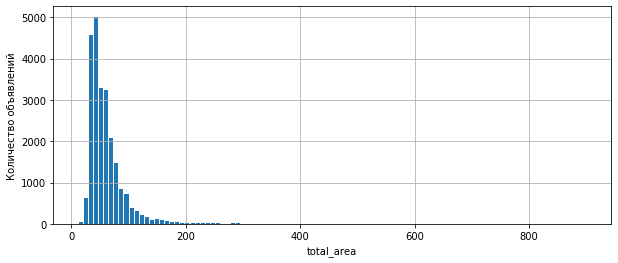

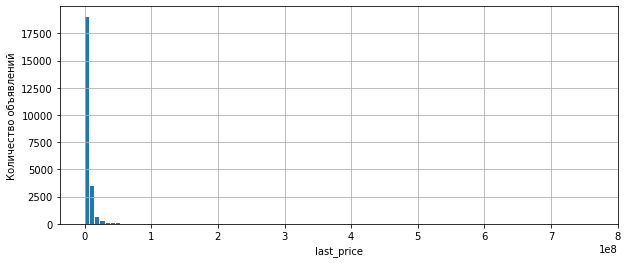

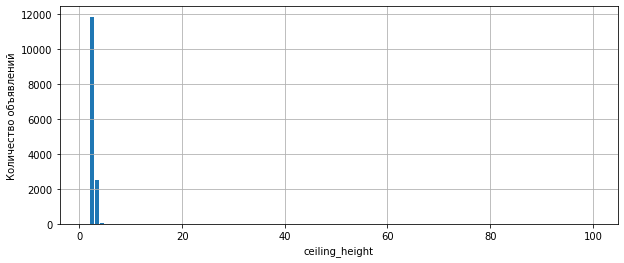

In [338]:
columns_to_plot = ['total_area', 'last_price', 'ceiling_height']
for column in columns_to_plot:
    realty_data[realty_data[column] > 0][column].plot.hist(
    grid=True, bins=100, figsize=(10,4), rwidth=0.8
    )
    plt.xlabel(column)
    plt.ylabel('Количество объявлений')
    plt.show()

Число комнат:

Text(0, 0.5, 'Количество объявлений')

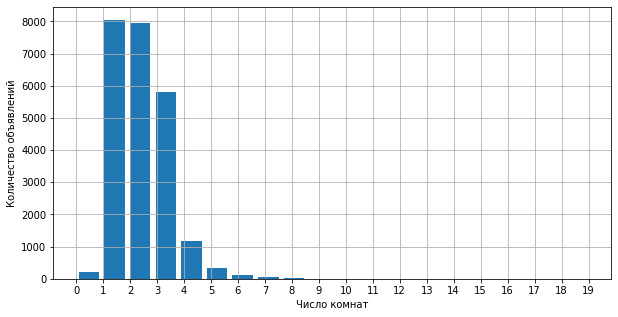

In [339]:
realty_data.rooms.plot.hist(
    grid=True, bins=20, figsize=(10,5), rwidth=0.8
)
plt.xticks(np.arange(0, 20, step=1))
plt.xlabel('Число комнат')
plt.ylabel('Количество объявлений')

#### Изучим время продажи квартир:
\
Взглянем на гистограмму, иллюстрирующую столбец days_exposition.

Text(0, 0.5, 'Количество объявлений')

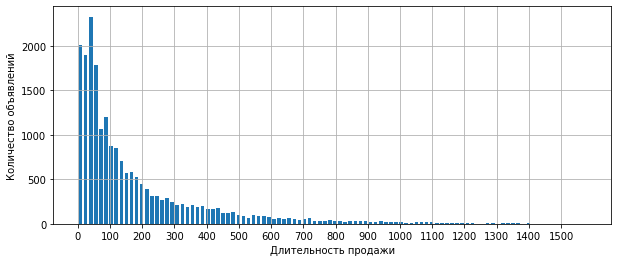

In [340]:
realty_data[realty_data.days_exposition > 0].days_exposition.plot.hist(
    grid=True, bins=100, figsize=(10,4), rwidth=0.7
)
plt.xticks(np.arange(0, 1600, step=100))
plt.xlabel('Длительность продажи')
plt.ylabel('Количество объявлений')

<font color='blue'> Здесь ты строишь ряд однотипных гистограмм, постарайся автоматизировать вывод с помощью цикла, чтоб написать код один раз, а выводились сразу все гистограммы подряд.</font>

Получили распределение Пуассона, что логично, т.к. имеем зависимость частоты событий от времени.\
Есть необычно много объявлений с малым временем продажи, приблизительно до 30 дней.\
Вероятно, это связано с выгодными предложениями, которые сразу же выкупались.\
\
**Посчитаем среднее и медиану:**

In [341]:
realty_data[realty_data.days_exposition > 0].days_exposition.describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Получаем среднее время продажи в 180 дней, при медиане в 95 дней.\
Это означает, что присутствует некоторое количество объявлений с чрезвычайно большим сроком продажи. Это также можно увидеть на гистограмме.
\
Поэтому в данном случае для оценки типичного срока продажи квартиры предпочтительнее использовать медиану.
\
Выходит, что для подавляющего большинства объявлений срок продажи лежит в пределах от 45 до 232 дней, однако есть и выбивающиеся значения. Так, минимальный срок продажи - 1 день, а максимальный - 1580 дней.

#### Уберём редкие и выбивающиеся значения:

Для определения необычных значений построим график "Ящик с усами".

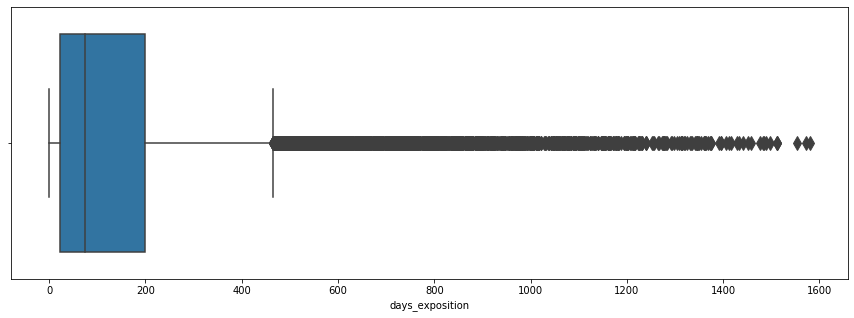

In [342]:
rcParams['figure.figsize'] = 15,5
sns.boxplot(x=realty_data.days_exposition, fliersize=10)

Судя по графику, за пределом стандартного размаха усов (1.5 межквартильного интервала) находится довольно много значений.\
Узнаем, сколько именно:

In [343]:
len(realty_data.query('days_exposition > 232*1.5'))

3267

Полученное значение больше 10% от размера всей таблицы. Удаление такого количества данных может негативно сказаться на результатах исследования, поэтому зададим значение дней, после которого будем считать, что объявление размещено слишком долго, вручную.\
\
Судя по графику выше, после отметки в 1000 дней, количество объявлений заметно сокращается.\
**Будем считать срок продажи более 1000 дней необычно большим.**
\
Посмотрим, каков процент таких объявлений:

In [344]:
len(realty_data.query('days_exposition > 1000')) / len(realty_data) * 100

1.164606101523271

Получаем чуть больше процента.
Можем смело удалять эти значения.

In [345]:
index_to_drop = realty_data[realty_data.days_exposition > 1000].index
realty_data = realty_data.drop(index_to_drop).reset_index(drop=True)

#### Оценим влияние различных факторов на стоимость квартиры.

Для оценки влияния сразу нескольких параметров, воспользуемся методом heatmap библиотека seaborn.

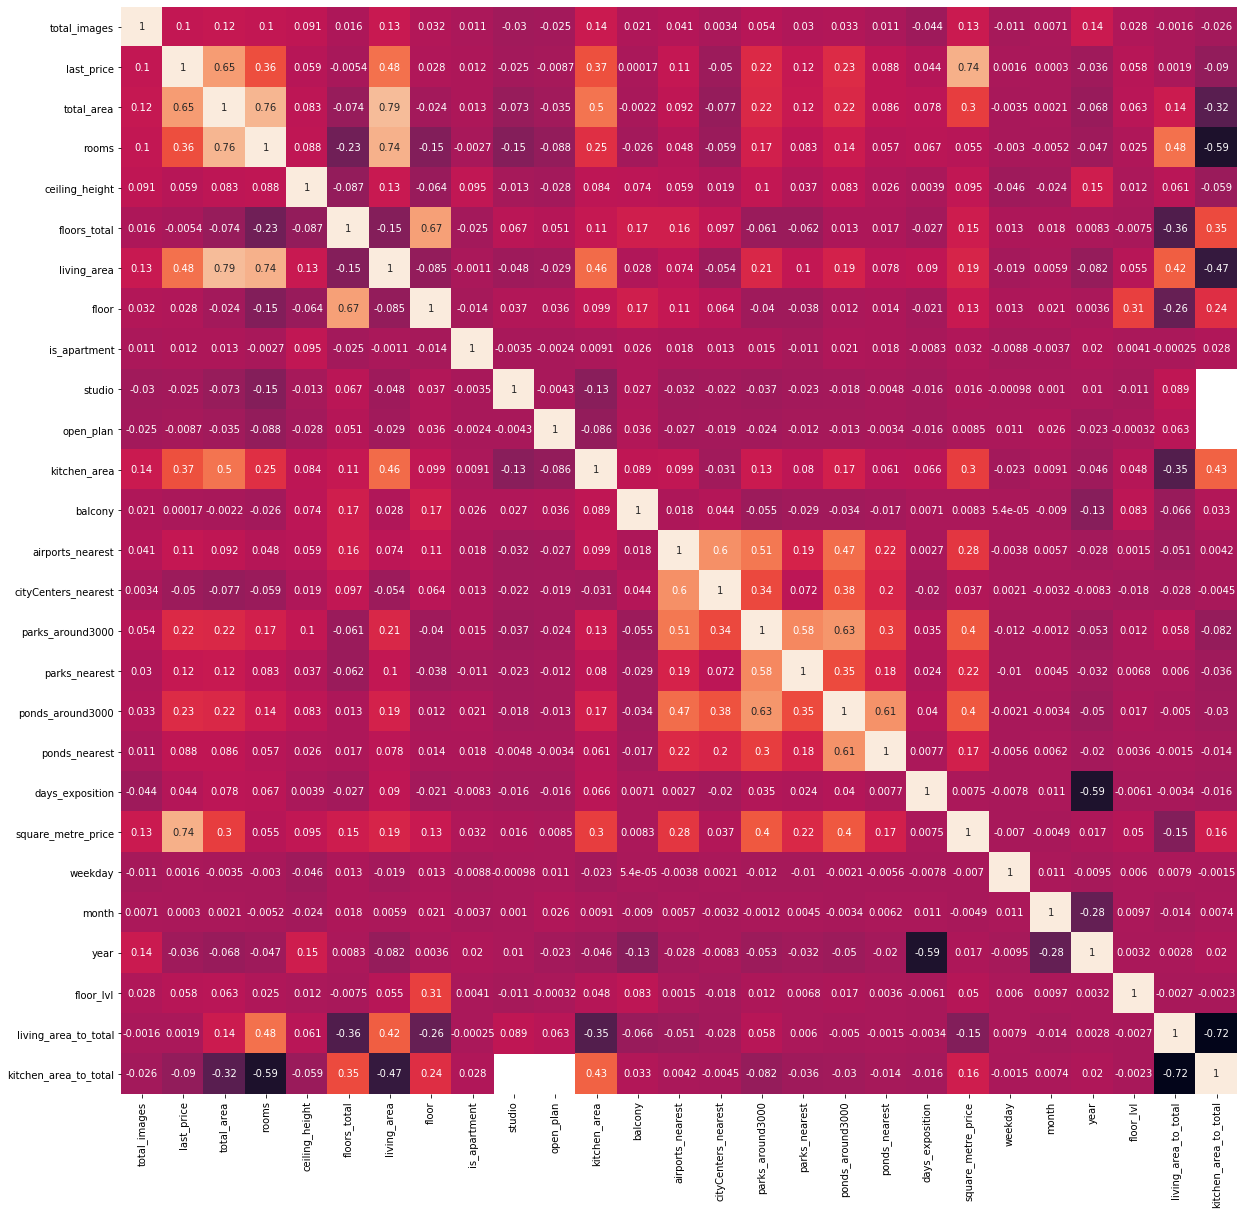

In [346]:
plt.figure(figsize=(20,20))
sns.heatmap(
    realty_data.corr(), annot=True, cbar=False
)

Исходя из этих данных, можно сделать следующие выводы о влиянии различных факторов на цену:
- Есть прямая зависимость между метражом квартиры и её ценой.
- Количество комнат также влияет на цену, однако меньше.
- Присутствует обратная зависимость между ценой и расстоянием до центра.
- Нет зависимости между датой размещения и ценой квартиры.
- Нет зависимости между ценой квартиры и этажом, на котором она находится.

#### Вычислим среднюю цену квадратного метра для 10 населенных пунктов с самым большим числом объявлений
Для воспользуемся сводной таблицей.

In [347]:
(realty_data
.pivot_table(
    index='locality_name', values='square_metre_price', aggfunc=['mean', 'count']
)
.sort_values(('count', 'square_metre_price'), ascending=False)
.head(10)
.sort_values(('mean', 'square_metre_price'), ascending=False)
)

,mean,count
,square_metre_price,square_metre_price
locality_name,,
Санкт-Петербург,114715.317543,15516
Пушкин,103228.201657,362
деревня Кудрово,92421.074830,294
посёлок Парголово,90102.711656,326
посёлок Мурино,85867.390716,517
посёлок Шушары,78615.348624,436
Колпино,75371.267857,336
Гатчина,68745.693811,307


Видим, что **Санкт-Петербург** лидирует как по количеству поданных объявлений, так и по средней стоимости квадратного метра, составляющей приблизительно **115 тыс. рублей за $м^2$.**\
Населенным пунктом, с самой низкой ценой за квадратный метр, оказался **Выборг**, при цене **58 тыс. рублей за $м^2$**.

#### Определим, какую зону Санкт-Петербурга можно считать центром.

Для этого создадим столбец city_center_km, в который добавим расстояние до центра в километрах. Значения округлим до целых.

Для удобства создадим отдельную таблицу с объявлениями Санкт-Петербурга:

In [348]:
realty_data_spb = realty_data[realty_data.locality_name == 'Санкт-Петербург'].reset_index(drop=True)
realty_data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl,living_area_to_total,kitchen_area_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755,-1,120370,3,3,2019,2,0.472222,0.231481
1,10,5196000,56.0,2015-08-20,2,-1.00,5,34.3,4,False,...,2,574,558,92785,3,8,2015,2,0.612500,0.148214
2,0,64900000,159.0,2015-07-24,3,-1.00,14,-1.0,9,False,...,3,234,424,408176,4,7,2015,2,NaN,NaN
3,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,48,121,100000,1,6,2018,2,0.320000,0.410000
4,5,7915000,71.6,2019-04-18,2,-1.00,24,-1.0,22,False,...,0,-1,-1,110544,3,4,2019,2,NaN,0.263966


Теперь создадим столбец city_center_km, и добавим его в таблицу с данными о Санкт-Петербурге.

In [349]:
def meters_to_km(row):
    try:
        meters = row.cityCenters_nearest
        kilometers = round(meters/1000)
        converted_values = []
        converted_values.append(kilometers)
        return int(kilometers)
    except:
        return np.nan

realty_data_spb['city_center_km'] = realty_data_spb.apply(meters_to_km, axis=1)
realty_data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl,living_area_to_total,kitchen_area_to_total,city_center_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,755,-1,120370,3,3,2019,2,0.472222,0.231481,16
1,10,5196000,56.0,2015-08-20,2,-1.00,5,34.3,4,False,...,574,558,92785,3,8,2015,2,0.612500,0.148214,14
2,0,64900000,159.0,2015-07-24,3,-1.00,14,-1.0,9,False,...,234,424,408176,4,7,2015,2,NaN,NaN,7
3,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,48,121,100000,1,6,2018,2,0.320000,0.410000,8
4,5,7915000,71.6,2019-04-18,2,-1.00,24,-1.0,22,False,...,-1,-1,110544,3,4,2019,2,NaN,0.263966,12


Для расчета средней цены за километр воспользуемся сводной таблицей.

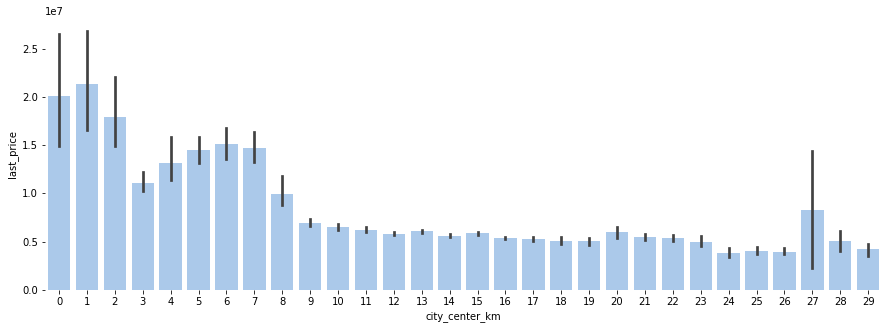

In [350]:
sns.set_color_codes('pastel')
sns.barplot(
data=realty_data_spb, x='city_center_km', y='last_price', color='b'
)
sns.despine(left=True, bottom=True)

Видим, что после 7 километров цена довольно резко падает, значит будем считать, что в "центре" находятся квартиры, расположенные в радиусе 7 километров включительно.

#### Проанализируем сегмент квартир в центре.

In [351]:
realty_data_spb.query('city_center_km < 8').describe().head(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl,living_area_to_total,kitchen_area_to_total,city_center_km
count,3502.000000,3.502000e+03,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,...,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3195.000000,3155.000000,3502.000000
mean,10.253855,1.483816e+07,92.593569,2.813821,1.650328,7.120503,49.228438,4.227013,12.919475,-0.270131,...,328.937179,180.421188,145330.351228,2.519132,6.408909,2017.244432,2.066533,0.581137,0.173725,4.424043


In [352]:
realty_data_spb.describe().head(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,ponds_nearest,days_exposition,square_metre_price,weekday,month,year,floor_lvl,living_area_to_total,kitchen_area_to_total,city_center_km
count,15516.000000,1.551600e+04,15516.000000,15516.0000,15516.000000,15516.000000,15516.000000,15516.000000,15516.000000,15516.000000,...,15516.000000,15516.000000,15516.000000,15516.000000,15516.000000,15516.000000,15516.000000,14392.000000,14150.00000,15516.0000
mean,10.203403,8.016920e+06,64.473917,2.1657,1.441357,11.344161,34.060963,6.246455,10.045358,0.095837,...,263.483243,145.047951,114715.317543,2.559745,6.420663,2017.383604,2.019464,0.565882,0.18586,11.5785


Сравнивая полученные значения в строке mean, делаем следующие выводы:
- Квартиры в центре дороже.
- Средняя площадь квартир в центре выше
- Число комнат и высота потолков больше

Для сравнения факторов, вляющих на цену квартиры в центре и по всему городу,
воспользуемся матрицей корреляции.

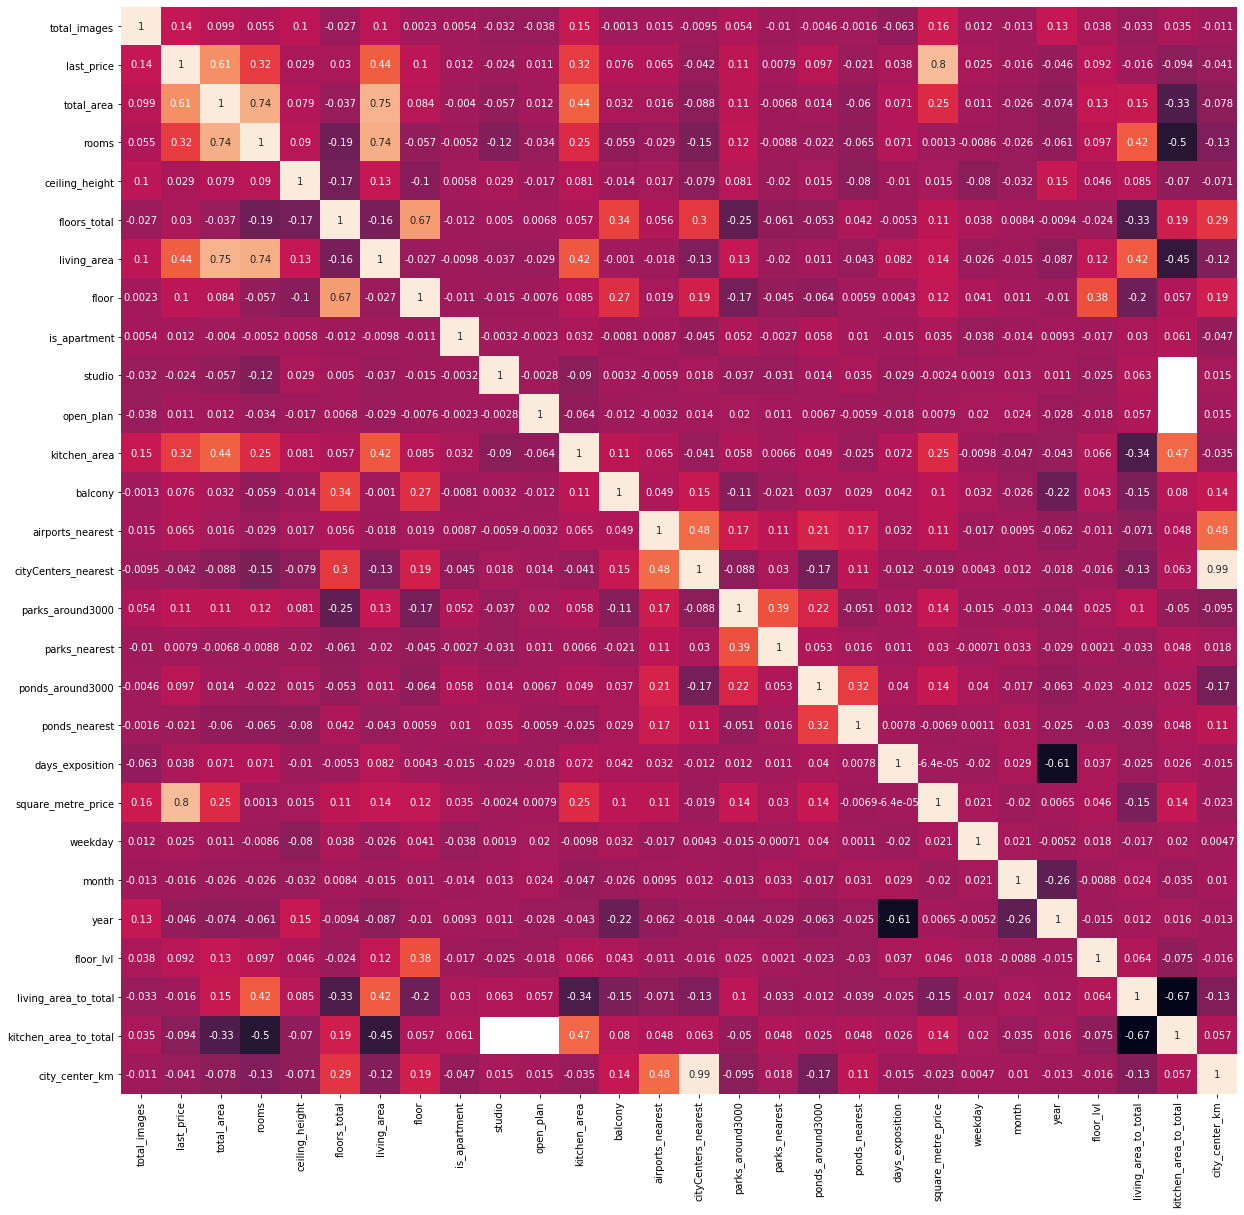

In [353]:
plt.figure(figsize=(20,20))
sns.heatmap(
realty_data_spb.query('city_center_km < 8').corr(), annot=True, cbar=False
)

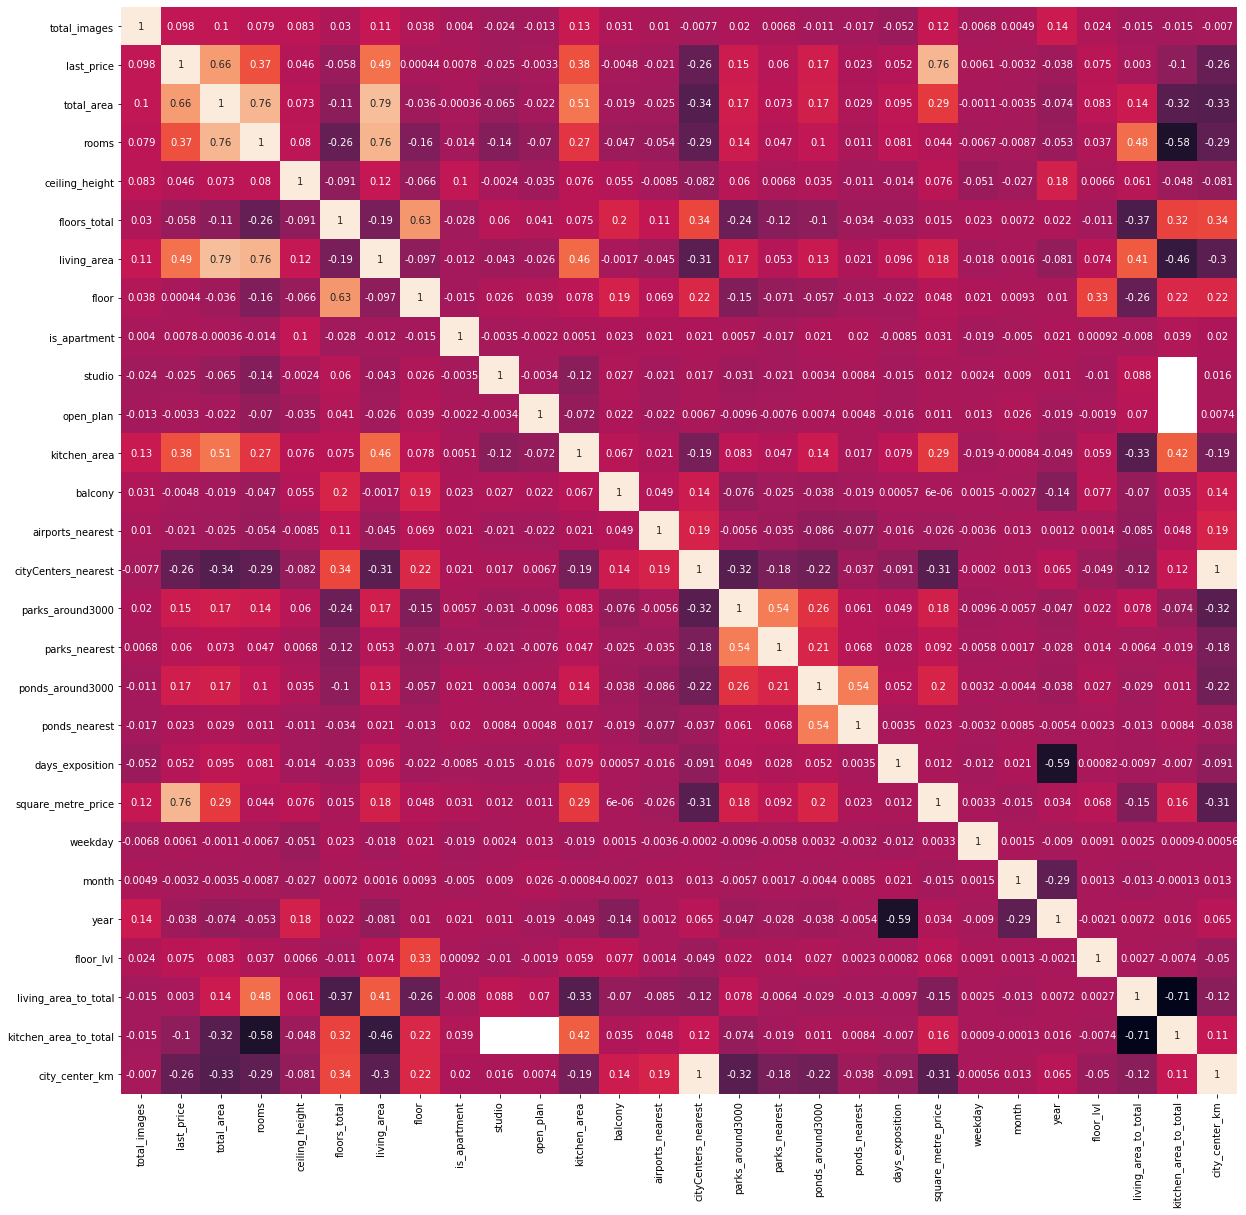

In [354]:
plt.figure(figsize=(20,20))
sns.heatmap(
realty_data_spb.corr(), annot=True, cbar=False
)

Сравнивая полученные коэффициенты корреляции для квартир в центре с общими по городу, приходим к выводу, что цена на квартиры в центре в сравнении со всем городом:
- Меньше коррелирует с площадью (0.61 в центре против 0.66 по городу)
- Меньше коррелирует с количеством комнат (0.32 в центре против 0.37 по городу)
- Также практически не коррелирует с этажом
- Намного меньше коррелирует с удаленностью от центра (-0.043 в центре против -0.26 по городу)
- Меньше коррелирует с количеством парков и прудов поблизости (в среднем, коэффициент корреляции ниже на 0.05)
- Дата публикации в целом не влияет на цену.
<br>

В целом, основные факторы, влияющие на стоимость квартиры в центре, остаются теми же, что и для всего города, за исключением удаленности от центра. Последний факт можно трактовать так: Если квартира расположена в центре, людям не важно, где конкретно она находится.

### Шаг 5. Общий вывод

**На первом этапе были заполнены пропуски в столбце is_apartment, пропущенные значения в других столбцах заменены на маркер "-1", а также была проведена работа с типами данных:**
- дата выставления объявления приведена к формату datetime64.
- для экономии ресурсов, в столбцах с целочисленными значениями тип данных float заменен на int.
<br>

**В таблицу были добавлены необходимые для анализа данные:**
- square_metre_price - Цена квадратного метра
- weekday, month, year - День недели, месяц, год публикации объявления
- floor_lvl - Этаж квартиры (первый/последний/другой)
- living_area_to_total - Соотношение жилой и общей площади
- kitchen_area_to_total - Отношение площади кухни к общей
<br>

**Построены гистограммы наиболее важных для анализа параметров**
- Площадь
- Цена
- Число комнат
- Высота потолков

**Проанализировано время продажи квартир, удалены выбивающиеся значения.**
\
Срок продажи более 1000 дней считается необычно большим. Объявления с таким сроком продажи составляют чуть более 1% от числа всех объявлений.

**Проведена оценка влияния различных факторов на стоимость квартиры**
\
В ходе данной оценки было выявлено, что:
- Есть прямая зависимость между метражом квартиры и её ценой.
- Количество комнат также влияет на цену, однако меньше.
- Присутствует обратная зависимость между ценой и расстоянием до центра.
- Нет зависимости между датой размещения и ценой квартиры.
- Нет зависимости между ценой квартиры и этажом, на котором она находится.

**Определена средняя цена квадратного метра для 10 населённых пунктов с самым большим числом объявлений**

Среди этих населенных пунктов выделяется **Санкт-Петербург** с числом объявлений более 15 тыс. и средней стоимости **115 тыс. рублей за $м^2$**. Среди этих населенных пунктов самая низкая цена за квадратный метр в **Выборге - 58 тыс. рублей за $м^2$**.

**Определена центральная зона Санкт-Петербурга и проанализирован сегмент квартир в этой зоне**

Построив гистограмму, показывающую, зависимость средней цены квартиры в зависимости от удаленности от центра города, было обнаружено резкое падение цены после отметки **7 км**. Эта область и была принята за "центр".
\

После сравнения квартир в центре с квартирами всего города, было выявлено, что:
- Квартиры в центре дороже.
- Средняя площадь квартир в центре выше
- Число комнат и высота потолков больше

**Проведено сравнение факторов, влияющих на цену квартир в центре, и по городу в целом**

Из этого сравнения следует, что цена на квартиры в центре:
- Меньше коррелирует с площадью (0.61 в центре против 0.66 по городу)
- Меньше коррелирует с количеством комнат (0.32 в центре против 0.37 по городу)
- Также практически не коррелирует с этажом
- Намного меньше коррелирует с удаленностью от центра (-0.043 в центре против -0.26 по городу)
- Меньше коррелирует с количеством парков и прудов поблизости (в среднем, коэффициент корреляции ниже на 0.05)

### Даны ответы на все поставленные вопросы.

<font color='blue'> В целом получился очень хороший проект. Анализ достаточно полный и наглядны. Чтоб довести проект до отличного постарайся доразобраться с предобработкой и автоматизировать вывод однотипных гистограмм..</font>

### Чек-лист готовности проекта

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод